In [1]:
%matplotlib inline
import streamlit as st
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
from neuralprophet import NeuralProphet

/opt/miniconda3/envs/neuralprophet_env/lib/python3.9/site-packages/plotly_resampler/aggregation/aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
def get_asset_tickers():
    return {
        "Apple Inc. (AAPL)": "AAPL",
        "Tesla Inc. (TSLA)": "TSLA",
        "USD/UAH (Курс долара до гривні)": "USDUAH=X",
        "Gold (Золото)": "GC=F",
        "Cocoa Futures (Ф'ючерси на какао)": "CC=F",
        "Coffee Futures (Ф'ючерси на каву)": "KC=F",
        "Bitcoin to USD (Біткоїн за долари)": "BTC-USD",
        "Ethereum to USD (Ефір за долари)": "ETH-USD",
        "S&P 500 Index (SP500)": "^GSPC",
        "Real Estate Investment Trust (VNQ)": "VNQ"
    }

In [3]:
def get_stock_data(tickers, retries=3, delay=5):
    for i in range(retries):
        try:
            data = yf.download(list(tickers.values()), period="360d", interval="1d", auto_adjust=True)
            if not data.empty:
                return data["Close"].dropna()
        except Exception as e:
            time.sleep(delay)
    return None

data = get_stock_data(get_asset_tickers())

[*********************100%***********************]  10 of 10 completed


In [4]:
def plot_price_dynamics(df):
    fig, axes = plt.subplots(4, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    date_index = df.index
    midpoint = len(date_index) // 2  # Halfway point to plot only first half of data
    
    for i, asset in enumerate(df.columns):
        if i >= 12:  # Limit to 12 charts
            break
        
        axes[i].plot(date_index, df[asset], color='gray', alpha=0.3)  # Full range for context
        axes[i].plot(date_index[:midpoint], df[asset].iloc[:midpoint], color='blue')  # First half of data
        axes[i].set_title(asset)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.draw()

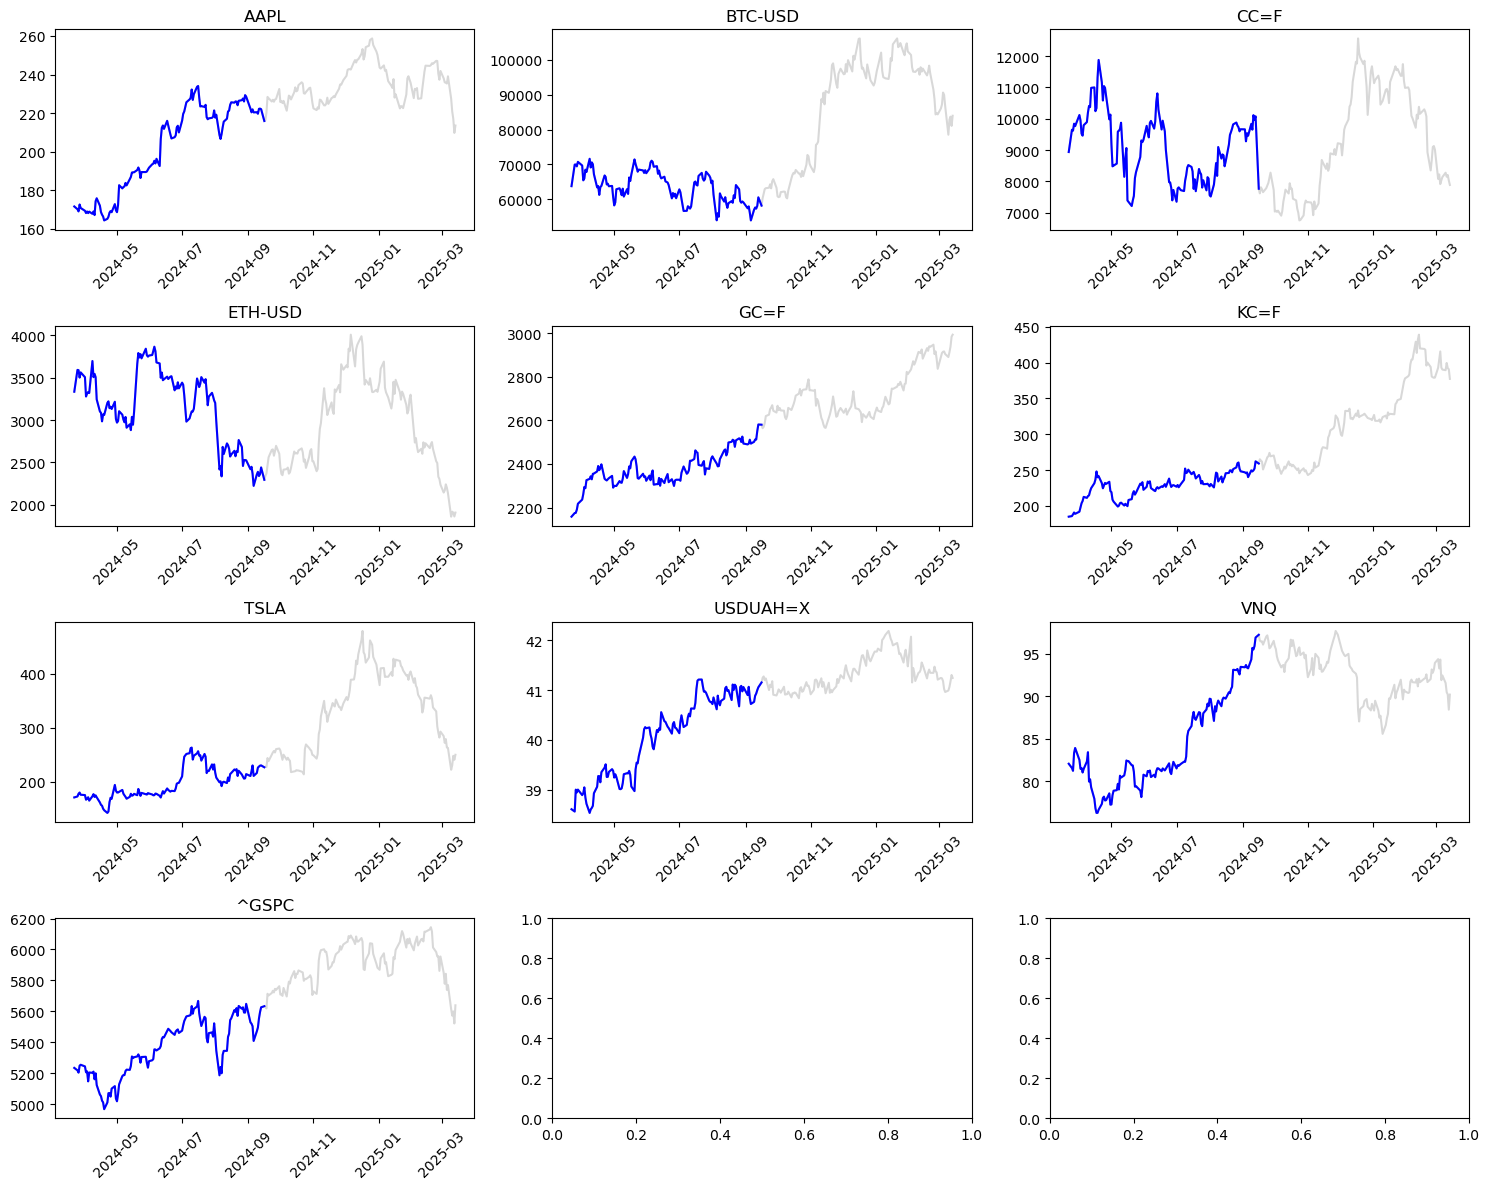

In [5]:
plot_price_dynamics(data)

In [6]:
def create_equal_weight_portfolio():
    """
    Create a DataFrame with an equal-weighted portfolio structure.
    
    Returns:
        pd.DataFrame: Portfolio structure with columns ["Тікер", "% вкладення"]
    """
    asset_tickers = get_asset_tickers()  # Get dictionary of asset names and tickers
    num_assets = len(asset_tickers)  # Count assets
    equal_weight = 100 / num_assets  # Distribute 100% equally

    # Create DataFrame
    df_structure = pd.DataFrame({
        "Тікер": list(asset_tickers.values()),
        "% вкладення": [equal_weight] * num_assets
    })

    return df_structure

In [7]:
equal_portfolio = create_equal_weight_portfolio()
equal_portfolio

,Тікер,% вкладення
0,AAPL,10.0
1,TSLA,10.0
2,USDUAH=X,10.0
3,GC=F,10.0
4,CC=F,10.0
5,KC=F,10.0
6,BTC-USD,10.0
7,ETH-USD,10.0
8,^GSPC,10.0
9,VNQ,10.0


In [8]:
df_structure = equal_portfolio.copy()
df_structure["% вкладення"] /= 100  # Convert from percent to decimal
df_structure

,Тікер,% вкладення
0,AAPL,0.1
1,TSLA,0.1
2,USDUAH=X,0.1
3,GC=F,0.1
4,CC=F,0.1
5,KC=F,0.1
6,BTC-USD,0.1
7,ETH-USD,0.1
8,^GSPC,0.1
9,VNQ,0.1


In [9]:
# Filter df_prices to include only assets in the portfolio
tickers = df_structure["Тікер"].values
df_prices = data[tickers]

In [10]:
tickers

array(['AAPL', 'TSLA', 'USDUAH=X', 'GC=F', 'CC=F', 'KC=F', 'BTC-USD',
       'ETH-USD', '^GSPC', 'VNQ'], dtype=object)

In [11]:
df_prices

Ticker,AAPL,TSLA,USDUAH=X,GC=F,CC=F,KC=F,BTC-USD,ETH-USD,^GSPC,VNQ
Date,,,,,,,,,,
2024-03-22,171.470352,170.830002,38.613033,2158.100098,8939.0,184.850006,63778.761719,3333.687988,5234.180176,82.040237
2024-03-25,170.047073,172.630005,38.566799,2174.800049,9649.0,185.649994,69958.812500,3590.883789,5218.189941,81.535797
2024-03-26,168.912415,177.669998,39.005493,2175.600098,9622.0,188.050003,69987.835938,3587.504883,5203.580078,81.205971
2024-03-27,172.495499,179.830002,38.949745,2190.600098,9843.0,190.649994,69455.343750,3500.115234,5248.490234,83.301353
2024-03-28,170.674103,175.789993,39.005970,2217.399902,9766.0,188.850006,70744.953125,3561.293945,5254.350098,83.893112
...,...,...,...,...,...,...,...,...,...,...
2025-03-10,227.479996,222.149994,40.989616,2891.000000,8279.0,389.350006,78532.000000,1861.151367,5614.560059,91.529999
2025-03-11,220.839996,230.580002,41.062454,2912.899902,8151.0,399.450012,82862.210938,1919.844971,5572.069824,90.459999
2025-03-12,216.979996,248.089996,41.173794,2939.100098,8204.0,392.200012,83722.359375,1908.982666,5599.299805,90.180000


In [12]:
# Compute daily returns
df_returns = df_prices.pct_change().dropna()
df_returns

Ticker,AAPL,TSLA,USDUAH=X,GC=F,CC=F,KC=F,BTC-USD,ETH-USD,^GSPC,VNQ
Date,,,,,,,,,,
2024-03-25,-0.008300,0.010537,-0.001197,0.007738,0.079427,0.004328,0.096898,0.077151,-0.003055,-0.006149
2024-03-26,-0.006673,0.029195,0.011375,0.000368,-0.002798,0.012928,0.000415,-0.000941,-0.002800,-0.004045
2024-03-27,0.021213,0.012157,-0.001429,0.006895,0.022968,0.013826,-0.007608,-0.024359,0.008631,0.025803
2024-03-28,-0.010559,-0.022466,0.001444,0.012234,-0.007823,-0.009441,0.018567,0.017479,0.001116,0.007104
2024-04-01,-0.008456,-0.003242,-0.002822,0.008614,0.036248,0.015621,-0.014740,-0.015799,-0.002014,-0.016767
...,...,...,...,...,...,...,...,...,...,...
2025-03-10,-0.048480,-0.154262,0.000716,-0.004716,0.016951,-0.002178,-0.094656,-0.129891,-0.026973,-0.009630
2025-03-11,-0.029189,0.037947,0.001777,0.007575,-0.015461,0.025941,0.055139,0.031536,-0.007568,-0.011690
2025-03-12,-0.017479,0.075939,0.002711,0.008995,0.006502,-0.018150,0.010380,-0.005658,0.004887,-0.003095


In [13]:
# Compute portfolio return: weighted sum of asset returns
weights = df_structure.set_index("Тікер")["% вкладення"].reindex(df_returns.columns).values
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [14]:
portfolio_returns = df_returns @ weights  # Matrix multiplication
portfolio_returns

Date
2024-03-25    0.025738
2024-03-26    0.003702
2024-03-27    0.007810
2024-03-28    0.000766
2024-04-01   -0.000336
                ...   
2025-03-10   -0.045312
2025-03-11    0.009601
2025-03-12    0.006503
2025-03-13   -0.015966
2025-03-14    0.010844
Length: 244, dtype: float64

In [15]:
mean_return = portfolio_returns.mean() * 252  # Annualized return
mean_return

0.2519186011833396

In [16]:
std_dev = portfolio_returns.std() * np.sqrt(252)  # Annualized volatility
std_dev

0.2025213251873146

In [17]:
risk_free_rate = 0.02

# Compute Sharpe Ratio
sharpe_ratio = (mean_return - risk_free_rate) / std_dev

In [18]:
sharpe_ratio

1.14515644695113

In [19]:
def compute_sharpe_ratio(df_structure, df_prices, risk_free_rate):
    """
    Calculate the Sharpe ratio of a portfolio.
    
    Parameters:
        df_structure (pd.DataFrame): DataFrame with columns ["Тікер", "% вкладення"]
        df_prices (pd.DataFrame): DataFrame where index is dates, columns are tickers, and values are prices
        risk_free_rate (float): Annualized risk-free rate (default: 2%)
    
    Returns:
        float: Sharpe ratio of the portfolio
    """
    
    # Convert allocation percentages to weights (ensure sum = 1)
    df_structure = df_structure.copy()
    df_structure["% вкладення"] /= 100  # Convert from percent to decimal
    
    # Filter df_prices to include only assets in the portfolio
    tickers = df_structure["Тікер"].values
    df_prices = df_prices[tickers]
    
    # Compute daily returns
    df_returns = df_prices.pct_change().dropna()
    
    # Compute portfolio return: weighted sum of asset returns
    weights = df_structure.set_index("Тікер")["% вкладення"].reindex(df_returns.columns).values
    portfolio_returns = df_returns @ weights  # Matrix multiplication

    # Compute portfolio statistics
    mean_return = portfolio_returns.mean() * 252  # Annualized return
    std_dev = portfolio_returns.std() * np.sqrt(252)  # Annualized volatility

    # Compute Sharpe Ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev

    return sharpe_ratio

In [20]:
risk_free_rate = 0.02
compute_sharpe_ratio(equal_portfolio, data, risk_free_rate)

1.14515644695113

In [21]:
df_returns = df_prices.pct_change().dropna()
df_returns

Ticker,AAPL,TSLA,USDUAH=X,GC=F,CC=F,KC=F,BTC-USD,ETH-USD,^GSPC,VNQ
Date,,,,,,,,,,
2024-03-25,-0.008300,0.010537,-0.001197,0.007738,0.079427,0.004328,0.096898,0.077151,-0.003055,-0.006149
2024-03-26,-0.006673,0.029195,0.011375,0.000368,-0.002798,0.012928,0.000415,-0.000941,-0.002800,-0.004045
2024-03-27,0.021213,0.012157,-0.001429,0.006895,0.022968,0.013826,-0.007608,-0.024359,0.008631,0.025803
2024-03-28,-0.010559,-0.022466,0.001444,0.012234,-0.007823,-0.009441,0.018567,0.017479,0.001116,0.007104
2024-04-01,-0.008456,-0.003242,-0.002822,0.008614,0.036248,0.015621,-0.014740,-0.015799,-0.002014,-0.016767
...,...,...,...,...,...,...,...,...,...,...
2025-03-10,-0.048480,-0.154262,0.000716,-0.004716,0.016951,-0.002178,-0.094656,-0.129891,-0.026973,-0.009630
2025-03-11,-0.029189,0.037947,0.001777,0.007575,-0.015461,0.025941,0.055139,0.031536,-0.007568,-0.011690
2025-03-12,-0.017479,0.075939,0.002711,0.008995,0.006502,-0.018150,0.010380,-0.005658,0.004887,-0.003095


In [22]:
num_assets = df_returns.shape[1]
num_assets

10

In [23]:
# Initial equal-weight allocation
initial_weights = np.ones(num_assets) / num_assets
initial_weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [24]:
tickers = df_prices.columns
tickers

Index(['AAPL', 'TSLA', 'USDUAH=X', 'GC=F', 'CC=F', 'KC=F', 'BTC-USD',
       'ETH-USD', '^GSPC', 'VNQ'],
      dtype='object', name='Ticker')

In [25]:
# Function to minimize (negative Sharpe ratio)
def negative_sharpe(weights):
    df_structure = pd.DataFrame({"Тікер": tickers, "% вкладення": weights * 100})
    return -compute_sharpe_ratio(df_structure, df_prices, risk_free_rate)


In [26]:
# Constraints: sum of weights must be 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
constraints


{'type': 'eq', 'fun': <function __main__.<lambda>(w)>}

In [27]:
# Bounds: each weight between 0 and 1 (no short selling)
bounds = [(0, 1) for _ in range(num_assets)]
bounds

[(0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1)]

In [28]:
# Optimization
result = minimize(negative_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.9958293510699097
       x: [ 9.721e-02  1.879e-02  3.969e-01  3.413e-01  4.930e-15
            1.317e-01  1.408e-02  0.000e+00  3.309e-15  4.993e-15]
     nit: 17
     jac: [-2.172e-01 -2.154e-01 -2.162e-01 -2.168e-01  3.543e-01
           -2.194e-01 -2.173e-01  9.191e+00  6.434e-01 -7.379e-02]
    nfev: 196
    njev: 17

In [29]:
# Extract optimized weights
optimized_weights = result.x
optimized_weights

array([9.72102791e-02, 1.87897268e-02, 3.96898797e-01, 3.41276710e-01,
       4.92989409e-15, 1.31740928e-01, 1.40835585e-02, 0.00000000e+00,
       3.30879432e-15, 4.99254346e-15])

In [30]:
# Create portfolio structure DataFrame
df_optimized = pd.DataFrame({
    "Тікер": tickers,
    "% вкладення": optimized_weights * 100  # Convert to percentage
})
df_optimized["% вкладення"] = df_optimized["% вкладення"].apply(lambda x: f"{x:.2f}%")
df_optimized

,Тікер,% вкладення
0,AAPL,9.72%
1,TSLA,1.88%
2,USDUAH=X,39.69%
3,GC=F,34.13%
4,CC=F,0.00%
5,KC=F,13.17%
6,BTC-USD,1.41%
7,ETH-USD,0.00%
8,^GSPC,0.00%
9,VNQ,0.00%


In [31]:
def Markowitz_optimised_portfolio(df_prices, risk_free_rate=0.02):
    """
    Optimizes portfolio allocation using Markowitz mean-variance optimization 
    to maximize the Sharpe ratio and returns a readable DataFrame.
    """
    
    # Compute daily returns
    df_returns = df_prices.pct_change().dropna()
    num_assets = df_returns.shape[1]
    
    # Initial equal-weight allocation
    initial_weights = np.ones(num_assets) / num_assets
    tickers = df_prices.columns

    # Function to minimize (negative Sharpe ratio)
    def negative_sharpe(weights):
        df_structure = pd.DataFrame({"Тікер": tickers, "% вкладення": weights * 100})
        return -compute_sharpe_ratio(df_structure, df_prices, risk_free_rate)

    # Constraints: sum of weights must be 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Bounds: each weight between 0 and 1 (no short selling)
    bounds = [(0, 1) for _ in range(num_assets)]

    # Optimization
    result = minimize(negative_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    # Extract optimized weights
    optimized_weights = result.x

    # Create portfolio structure DataFrame
    df_optimized = pd.DataFrame({
        "Тікер": tickers,
        "% вкладення": optimized_weights  # Convert to percentage
    })

    return df_optimized

In [32]:
def calculate_yield(df_yield, df_investment, total_investment):
    """
    Обчислює підсумкову вартість інвестованих активів і дохід за ними.
    
    Параметри:
        df_yield (pd.DataFrame): DataFrame з колонками "Ticker" і "Дохідність".
        df_investment (pd.DataFrame): DataFrame з колонками "Тікер" і "% вкладення".
        total_investment (float): Загальна сума інвестування.
    
    Повертає:
        pd.DataFrame: Датафрейм із колонками "Тікер", "Вкладено", "Вартість на сьогодні", "Дохід".
    """
    # Об'єднання даних по тікерам
    df_result = df_investment.merge(df_yield, left_on="Тікер", right_on="Ticker", how="left")
    
    # Обчислення вкладених коштів у кожен актив
    df_result["Вкладено"] = (df_result["% вкладення"]) * total_investment
    
    # Обчислення вартості активу на сьогодні
    df_result["Вартість на сьогодні"] = df_result["Вкладено"] * (1 + df_result["Доходність"])
    
    # Обчислення доходу
    df_result["Дохід"] = df_result["Вкладено"] * df_result["Доходність"]
    
    # Вибираємо потрібні колонки та повертаємо результат
    return df_result[["Тікер", "Вкладено", "Вартість на сьогодні", "Дохід"]]

In [33]:
def calculate_returns(df):
    midpoint = len(df) // 2
    returns = (df.iloc[-1] - df.iloc[midpoint]) / df.iloc[midpoint]
    return returns.to_frame(name="Доходність")

In [34]:
total_investment = 1000

In [35]:
df_yield = calculate_returns(data)
df_train_historic_prices = data.iloc[:len(data) // 2]
markowitz_portfolio = Markowitz_optimised_portfolio(df_train_historic_prices)
markowitz_yield = calculate_yield(df_yield, markowitz_portfolio, total_investment)
markowitz_yield

,Тікер,Вкладено,Вартість на сьогодні,Дохід
0,AAPL,1.034857e+02,1.021348e+02,-1.350968e+00
1,BTC-USD,3.043060e-11,4.236930e-11,1.193869e-11
2,CC=F,9.591449e-12,9.928786e-12,3.373371e-13
3,ETH-USD,1.690250e-10,1.378258e-10,-3.119920e-11
4,GC=F,1.683872e+02,1.965776e+02,2.819039e+01
5,KC=F,6.244999e+01,8.889108e+01,2.644109e+01
6,TSLA,5.932303e-11,6.507909e-11,5.756055e-12
7,USDUAH=X,5.205327e+02,5.205288e+02,-3.851699e-03
8,VNQ,1.451444e+02,1.355879e+02,-9.556463e+00
9,^GSPC,1.032778e-11,1.033577e-11,7.991315e-15


In [36]:
def forecast_prices_neuralprophet(df_prices):
    """
    Forecasts asset prices using NeuralProphet for the same length as historical data.
    
    Parameters:
        df_prices (pd.DataFrame): DataFrame with historical prices (index = date, columns = tickers)

    Returns:
        pd.DataFrame: Combined historical and forecasted prices
    """
    
    forecast_days = len(df_prices)  # Forecast for the same number of days as history
    forecasted_prices = pd.DataFrame(index=pd.date_range(df_prices.index[-1], periods=forecast_days + 1, freq="D")[1:])

    for ticker in df_prices.columns:
        df = df_prices[[ticker]].reset_index()
        df.columns = ['ds', 'y']  # Rename for NeuralProphet

        model = NeuralProphet(n_forecasts=forecast_days)
        model.fit(df, freq='D')

        future = model.make_future_dataframe(df, periods=forecast_days)
        forecast = model.predict(future)

        forecasted_prices[ticker] = forecast['yhat1'].iloc[-forecast_days:].values  # Extract forecast

    # Combine historical and forecasted data
    df_combined = pd.concat([df_prices, forecasted_prices])

    return df_combined

In [37]:
df_forecast = forecast_prices_neuralprophet(df_train_historic_prices)
df_forecast

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 478
WARNING - (py.warnin

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
IN

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
IN

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
IN

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
IN

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
IN

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
IN

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
IN

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
IN

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
IN

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.082% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,AAPL,BTC-USD,CC=F,ETH-USD,GC=F,KC=F,TSLA,USDUAH=X,VNQ,^GSPC
2024-03-22,171.470352,63778.761719,8939.000000,3333.687988,2158.100098,184.850006,170.830002,38.613033,82.040237,5234.180176
2024-03-25,170.047073,69958.812500,9649.000000,3590.883789,2174.800049,185.649994,172.630005,38.566799,81.535797,5218.189941
2024-03-26,168.912415,69987.835938,9622.000000,3587.504883,2175.600098,188.050003,177.669998,39.005493,81.205971,5203.580078
2024-03-27,172.495499,69455.343750,9843.000000,3500.115234,2190.600098,190.649994,179.830002,38.949745,83.301353,5248.490234
2024-03-28,170.674103,70744.953125,9766.000000,3561.293945,2217.399902,188.850006,175.789993,39.005970,83.893112,5254.350098
...,...,...,...,...,...,...,...,...,...,...
2025-01-12,155.365112,28798.054688,8444.214844,577.734375,3385.718750,220.963272,184.213440,40.951389,78.026222,6872.796875
2025-01-13,240.609360,41196.558594,14563.123047,302.805542,2949.064209,319.981812,254.756683,41.210114,116.017929,6153.736328
2025-01-14,241.639282,40475.375000,14829.222656,260.221313,2951.583496,321.419373,255.549927,41.319130,116.234818,6165.721191
2025-01-15,241.779694,40015.218750,14872.688477,233.736450,2954.244385,322.145447,255.035721,41.328922,116.189842,6168.408691


In [38]:
markowitz_portfolio_forecasted = Markowitz_optimised_portfolio(df_forecast)

In [39]:
markowitz_portfolio_forecasted

,Тікер,% вкладення
0,AAPL,2.030186e-02
1,BTC-USD,2.221983e-12
2,CC=F,1.165579e-02
3,ETH-USD,5.573828e-12
4,GC=F,4.609311e-01
5,KC=F,0.000000e+00
6,TSLA,1.185767e-12
7,USDUAH=X,0.000000e+00
8,VNQ,1.680392e-01
9,^GSPC,3.390720e-01


In [40]:
markowitz_yield_forecasted = calculate_yield(df_yield, markowitz_portfolio_forecasted, total_investment)
markowitz_yield_forecasted

,Тікер,Вкладено,Вартість на сьогодні,Дохід
0,AAPL,2.030186e+01,2.003683e+01,-2.650333e-01
1,BTC-USD,2.221983e-09,3.093723e-09,8.717400e-10
2,CC=F,1.165579e+01,1.206573e+01,4.099413e-01
3,ETH-USD,5.573828e-09,4.544992e-09,-1.028836e-09
4,GC=F,4.609311e+02,5.380975e+02,7.716638e+01
5,KC=F,0.000000e+00,0.000000e+00,0.000000e+00
6,TSLA,1.185767e-09,1.300821e-09,1.150538e-10
7,USDUAH=X,0.000000e+00,0.000000e+00,-0.000000e+00
8,VNQ,1.680392e+02,1.569754e+02,-1.106388e+01
9,^GSPC,3.390720e+02,3.393343e+02,2.623634e-01


In [42]:
data=data.iloc[:-1]
df_forecast.index=data.index
df_forecast

,AAPL,BTC-USD,CC=F,ETH-USD,GC=F,KC=F,TSLA,USDUAH=X,VNQ,^GSPC
Date,,,,,,,,,,
2024-03-22,171.470352,63778.761719,8939.000000,3333.687988,2158.100098,184.850006,170.830002,38.613033,82.040237,5234.180176
2024-03-25,170.047073,69958.812500,9649.000000,3590.883789,2174.800049,185.649994,172.630005,38.566799,81.535797,5218.189941
2024-03-26,168.912415,69987.835938,9622.000000,3587.504883,2175.600098,188.050003,177.669998,39.005493,81.205971,5203.580078
2024-03-27,172.495499,69455.343750,9843.000000,3500.115234,2190.600098,190.649994,179.830002,38.949745,83.301353,5248.490234
2024-03-28,170.674103,70744.953125,9766.000000,3561.293945,2217.399902,188.850006,175.789993,39.005970,83.893112,5254.350098
...,...,...,...,...,...,...,...,...,...,...
2025-03-07,155.365112,28798.054688,8444.214844,577.734375,3385.718750,220.963272,184.213440,40.951389,78.026222,6872.796875
2025-03-10,240.609360,41196.558594,14563.123047,302.805542,2949.064209,319.981812,254.756683,41.210114,116.017929,6153.736328
2025-03-11,241.639282,40475.375000,14829.222656,260.221313,2951.583496,321.419373,255.549927,41.319130,116.234818,6165.721191


In [43]:
df_forecast.to_csv("forecast_prices.csv", index=True)

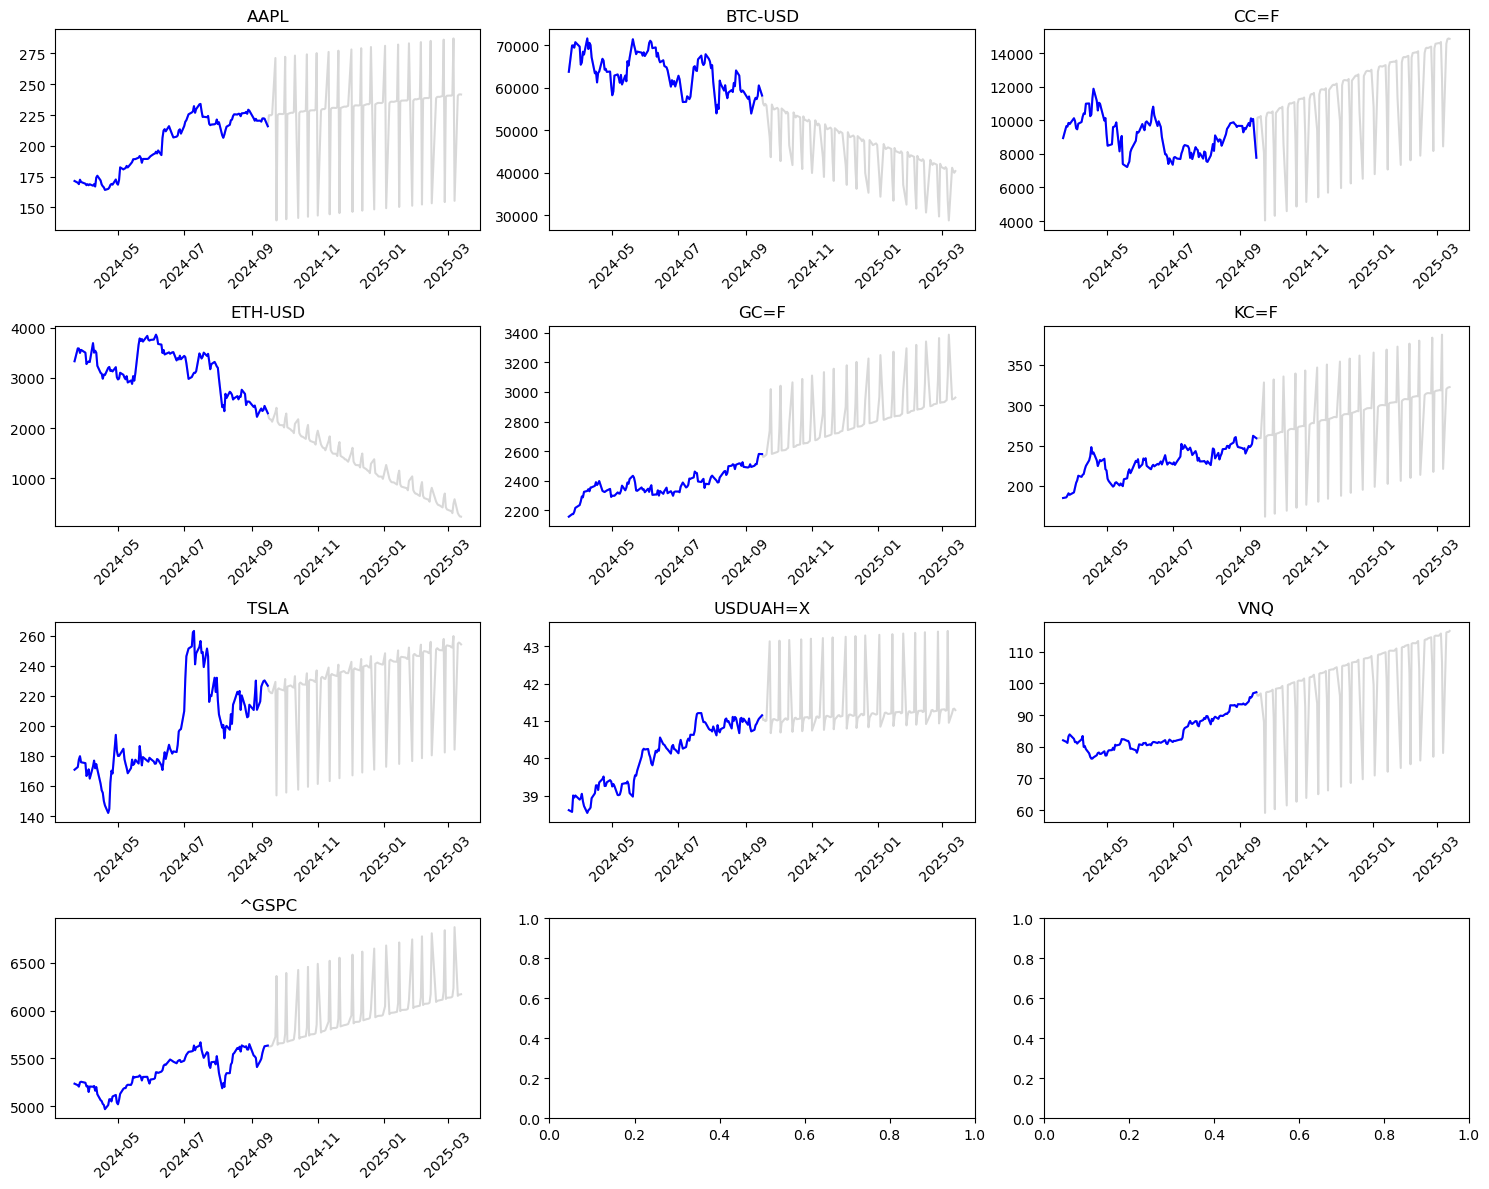

In [44]:
plot_price_dynamics(df_forecast)

In [45]:
df_train_historic_prices.to_csv("df_train_historic_prices.csv", index=True)

In [46]:
markowitz_portfolio_forecasted.to_csv("markowitz_portfolio_forecasted.csv", index=True)

In [47]:
test = pd.read_csv("markowitz_portfolio_forecasted.csv")

In [48]:
test

,Unnamed: 0,Тікер,% вкладення
0,0,AAPL,2.030186e-02
1,1,BTC-USD,2.221983e-12
2,2,CC=F,1.165579e-02
3,3,ETH-USD,5.573828e-12
4,4,GC=F,4.609311e-01
5,5,KC=F,0.000000e+00
6,6,TSLA,1.185767e-12
7,7,USDUAH=X,0.000000e+00
8,8,VNQ,1.680392e-01
9,9,^GSPC,3.390720e-01


In [49]:
test.describe()

,Unnamed: 0,% вкладення
count,10.00000,1.000000e+01
mean,4.50000,1.000000e-01
std,3.02765,1.687248e-01
min,0.00000,0.000000e+00
25%,2.25000,1.444821e-12
50%,4.50000,5.827896e-03
75%,6.75000,1.311049e-01
max,9.00000,4.609311e-01


In [56]:
portfolio_data = {
    "Тікер": ["AAPL", "GC=F", "KC=F", "TSLA", "USDUAH=X", "VNQ", "^GSPC"],
    "% вкладення": [23.2, 15.3, 16.5, 9.5, 13.7, 14.1, 7.5]  # Відсотки
}

# Конвертуємо у DataFrame та переводимо % у частки
df_portfolio = pd.DataFrame(portfolio_data)
df_portfolio["% вкладення"] = df_portfolio["% вкладення"] / 100

# Виводимо DataFrame
print(df_portfolio)

      Тікер  % вкладення
0      AAPL        0.232
1      GC=F        0.153
2      KC=F        0.165
3      TSLA        0.095
4  USDUAH=X        0.137
5       VNQ        0.141
6     ^GSPC        0.075


In [57]:
df_portfolio.to_csv("grok3_portfolio.csv", index=True)

In [70]:
def analyze_portfolios(portfolios: dict, df_prices: pd.DataFrame, initial_investment: float, risk_free_rate=0.02):
    """
    Analyzes multiple portfolios, calculating Sharpe ratio, return, final value, and profit.

    Parameters:
        portfolios (dict): Dictionary of portfolio DataFrames with structure {'Portfolio Name': df_structure}
        df_prices (pd.DataFrame): Historical price data (index = dates, columns = tickers)
        initial_investment (float): The total amount invested at the start.
        risk_free_rate (float): Risk-free rate for Sharpe ratio calculation (default = 2%).

    Returns:
        pd.DataFrame: Summary with Sharpe ratio, return, final value, and profit for each portfolio.
    """
    
    results = []

    for portfolio_name, df_structure in portfolios.items():
        # Ensure tickers in portfolio exist in df_prices
        tickers = df_structure["Тікер"].values
        valid_tickers = [ticker for ticker in tickers if ticker in df_prices.columns]
        
        if not valid_tickers:
            print(f"⚠️ Warning: No valid tickers found for {portfolio_name}. Skipping...")
            continue
        
        # Filter price data for selected assets
        df_selected_prices = df_prices[valid_tickers]
        
        # Compute Sharpe ratio
        sharpe_ratio = compute_sharpe_ratio(df_structure, df_selected_prices, risk_free_rate)
        
        # Compute portfolio returns
        weighted_returns = df_selected_prices.pct_change().dropna() * df_structure.set_index("Тікер")["% вкладення"]
        
        # Compute portfolio growth over time
        portfolio_value_series = (weighted_returns.sum(axis=1) + 1).cumprod()
        
        # Compute final portfolio value based on initial investment
        final_value = initial_investment * portfolio_value_series.iloc[-1]
        
        # Compute portfolio profit
        profit = final_value - initial_investment
        
        # Append results
        results.append({
            "Назва портфеля": portfolio_name,
            "коефіцієнт Шарпа": sharpe_ratio,
            "Вартість портфеля": final_value,
            "Дохід": profit
        })
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    return df_results

In [59]:
portfolios = {"Grok": df_portfolio, "NeuralProphet+Sharpe": markowitz_portfolio_forecasted, "Historic+Sharpe": markowitz_portfolio}

In [60]:
type(portfolios)

dict

In [71]:
portfolios_comparison = analyze_portfolios(portfolios, data, total_investment)

In [72]:
portfolios_comparison

,Назва портфеля,коефіцієнт Шарпа,Дохідність,Вартість портфеля,Дохід
0,Grok,-11.837955,0.001314,1362.793065,362.793065
1,NeuralProphet+Sharpe,-16.921533,0.000812,1211.390236,211.390236
2,Historic+Sharpe,-27.854559,0.000741,1194.758082,194.758082


In [73]:
def calculate_portfolio_performance(df_portfolio, a_date_prices, b_date_prices, total_investment):
    """
    Calculates the return and final value of a portfolio based on asset prices on two dates.

    Parameters:
        df_portfolio (pd.DataFrame): DataFrame with "Тікер" (tickers) and "% вкладення" (weights).
        a_date_prices (pd.DataFrame): DataFrame with asset prices on the start date (index should be one date).
        b_date_prices (pd.DataFrame): DataFrame with asset prices on the end date (index should be one date).
        total_investment (float): The total amount invested at the start.

    Returns:
        pd.DataFrame: DataFrame with columns "Дохідність портфеля", "Вартість портфеля".
    """
    
    # Ensure tickers in portfolio exist in price data
    tickers = df_portfolio["Тікер"].values
    valid_tickers = [ticker for ticker in tickers if ticker in a_date_prices.columns and ticker in b_date_prices.columns]
    
    if not valid_tickers:
        raise ValueError("⚠️ No valid tickers found in price data.")

    # Extract prices for selected tickers
    initial_prices = a_date_prices[valid_tickers].iloc[0]  # Prices at date A
    final_prices = b_date_prices[valid_tickers].iloc[0]    # Prices at date B

    # Calculate return for each asset
    returns = final_prices / initial_prices  # Return factor (e.g., 1.05 means +5%)

    # Calculate each asset's contribution to portfolio value
    df_portfolio = df_portfolio.set_index("Тікер")  # Ensure index is tickers
    df_portfolio = df_portfolio.loc[valid_tickers]  # Keep only valid tickers

    df_portfolio["Дохідність активу"] = returns
    df_portfolio["Вартість активу"] = total_investment * df_portfolio["% вкладення"] * df_portfolio["Дохідність активу"]

    # Calculate total portfolio value and return
    portfolio_value = df_portfolio["Вартість активу"].sum()
    portfolio_return = portfolio_value / total_investment - 1  # Convert to percentage return

    # Create output DataFrame
    df_result = pd.DataFrame({
        "Дохідність портфеля": [portfolio_return],
        "Вартість портфеля": [portfolio_value]
    })

    return df_result

In [75]:
a_date_prices = df_train_historic_prices.iloc[-1:]
a_date_prices

Ticker,AAPL,BTC-USD,CC=F,ETH-USD,GC=F,KC=F,TSLA,USDUAH=X,VNQ,^GSPC
Date,,,,,,,,,,
2024-09-16,215.844955,58192.507812,7767.0,2295.283691,2580.399902,259.049988,226.779999,41.151512,97.203011,5633.089844


In [76]:
b_date_prices = data.iloc[-1:]
b_date_prices

Ticker,AAPL,BTC-USD,CC=F,ETH-USD,GC=F,KC=F,TSLA,USDUAH=X,VNQ,^GSPC
Date,,,,,,,,,,
2025-03-13,209.679993,81066.703125,8031.0,1862.969604,2984.300049,390.600006,240.679993,41.301014,88.400002,5521.52002


In [78]:
calculate_portfolio_performance(df_portfolio, a_date_prices, b_date_prices, total_investment)

,Дохідність портфеля,Вартість портфеля
0,0.091178,1091.177621


In [79]:
def analyze_multiple_portfolios(portfolios: dict, a_date_prices: pd.DataFrame, b_date_prices: pd.DataFrame, total_investment: float):
    """
    Analyzes multiple portfolios and returns a combined DataFrame with performance results.

    Parameters:
        portfolios (dict): Dictionary of portfolio DataFrames with structure {'Portfolio Name': df_structure}
        a_date_prices (pd.DataFrame): Historical prices on the start date.
        b_date_prices (pd.DataFrame): Historical prices on the end date.
        total_investment (float): The total amount invested at the start.

    Returns:
        pd.DataFrame: Combined results with portfolio performance, indexed by portfolio names.
    """

    results = []

    for portfolio_name, df_portfolio in portfolios.items():
        # Compute performance for this portfolio
        df_result = calculate_portfolio_performance(df_portfolio, a_date_prices, b_date_prices, total_investment)
        
        # Add portfolio name as index
        df_result.index = [portfolio_name]
        
        # Append result to list
        results.append(df_result)

    # Combine all results into a single DataFrame
    df_combined = pd.concat(results)

    return df_combined

In [80]:
analyze_multiple_portfolios(portfolios, a_date_prices, b_date_prices, total_investment)

,Дохідність портфеля,Вартість портфеля
Grok,0.091178,1091.177621
NeuralProphet+Sharpe,0.050030,1050.030239
Historic+Sharpe,0.043861,1043.860760


In [81]:
df_yield

,Доходність
Ticker,
AAPL,-0.013055
BTC-USD,0.392325
CC=F,0.035171
ETH-USD,-0.184583
GC=F,0.167414
KC=F,0.423396
TSLA,0.097029
USDUAH=X,-0.000007
VNQ,-0.065841
